In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# HD143006 Tutorial Part 1

This tutorial is the first of an eventual three part series covering a real world application of RML imaging to the HD 143006 protoplanetary disk dataset observed as part of the DSHARP survey ([Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract)). In this tutorial (Part 1), we'll provide a brief introduction to the dataset itself, the MPoL package, and perform some brief diagnostic imaging to make sure we have the basics configured properly.

[Part 2](HD143006_Part_2.html) of the tutorial will demonstrate how to set up the optimization loop and to create an RML image.


## Viewing the CLEAN image

Before we dig into RML imaging or the MPoL package, let's get our bearings by looking at the fiducial image provided by the DSHARP survey, synthesized using the CLEAN algorithm. We can download the FITS file directly from the DSHARP survey page

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.utils.data import download_file

In [4]:
fname = download_file(
    "https://almascience.eso.org/almadata/lp/DSHARP/images/HD143006_continuum.fits",
    cache=True,
    pkgname="mpol",
)

The following commands load the FITS file and calculate the RA and DEC axes using information from the FITS header. For more information on reading FITS files in Python, please consult the [astropy documentation](https://docs.astropy.org/en/stable/io/fits/index.html).

In [5]:
hdul = fits.open(fname)
hdu = hdul[0]
clean_img = np.squeeze(hdu.data)
header = hdu.header
hdul.close()

In [6]:
# get the number of pixels in each direction
nx = header["NAXIS1"]
ny = header["NAXIS2"]
# RA coordinates
CDELT1 = 3600 * header["CDELT1"]  # Convert from units of degrees to arcsec

# DEC coordinates
CDELT2 = 3600 * header["CDELT2"]  # [arcsec]

# calculate the RA and DEC pixel centers
RA = (np.arange(nx) - nx / 2) * CDELT1  # [arcsec]
DEC = (np.arange(ny) - ny / 2) * CDELT2  # [arcsec]

# matplotlib imshow extent needs to include extra half-pixels.
ext = (
    RA[0] - CDELT1 / 2,
    RA[-1] + CDELT1 / 2,
    DEC[0] - CDELT2 / 2,
    DEC[-1] + CDELT2 / 2,
)  # [arcsec]

Here is the CLEAN image produced by the DSHARP team ([Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract)).

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

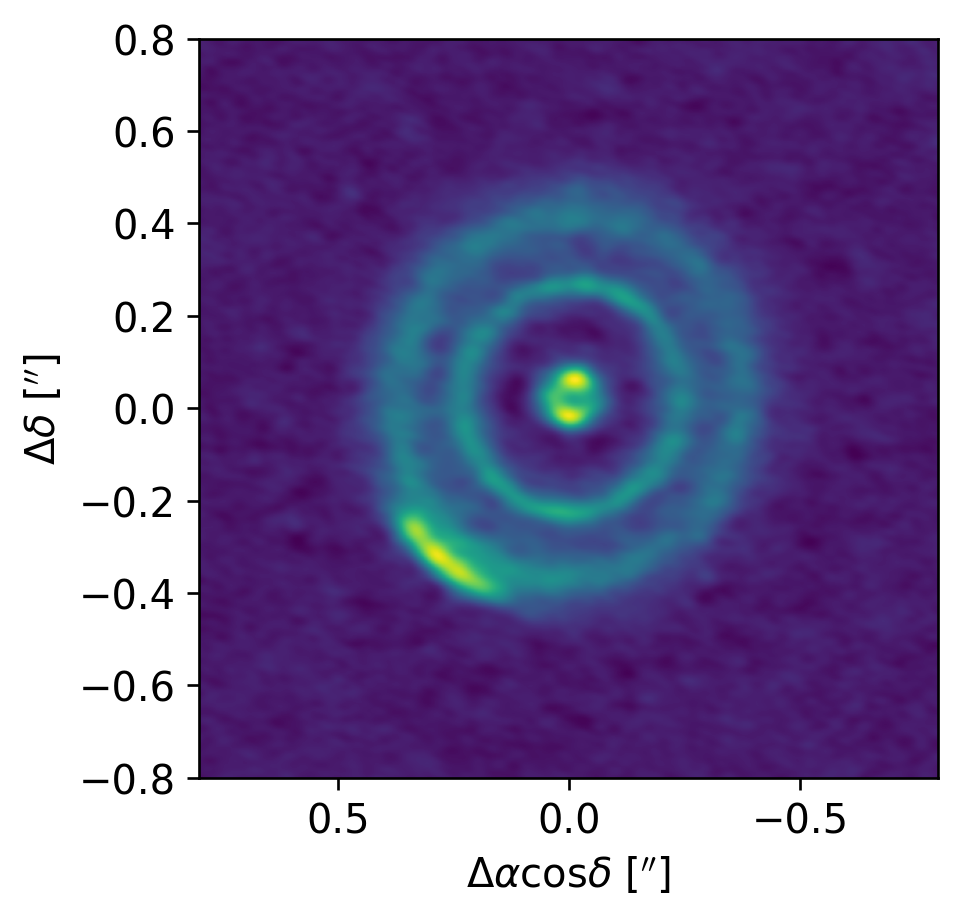

In [7]:
plt.imshow(clean_img, origin="lower", extent=ext)
# zooming in a little to focus on the disk
r = 0.8
plt.xlim(left=r, right=-r)
plt.ylim(top=r, bottom=-r)
# axis labels
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

## Plotting the Baselines

Now that we have an idea of what we're looking to image, let's load up the actual dataset. First, we'll download the raw visibilities. To speed things along for the purpose of this tutorial (and avoid introducing CASA as a package dependency), we've already extracted the visibility data as a `.npz` file, which we've made available on Zenodo.

More information on how to do this extraction in general is available on the [visread](https://mpol-dev.github.io/visread/) documentation page, and the specific commands used to produce this `.npz` file are available in the [mpoldatasets](https://github.com/MPoL-dev/mpoldatasets/tree/main/products/HD143006-DSHARP-continuum) package.

In [8]:
fname = download_file(
    "https://zenodo.org/record/4904794/files/HD143006_continuum.npz",
    cache=True,
    pkgname="mpol",
)

In [9]:
# load extracted visibilities from npz file
d = np.load(fname)
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]

To get an idea of the $u,v$ coverage of the dataset, let's plot the $u,v$ coordinates of the visibilities, as we've done in the [cross-validation tutorial](https://mpol-dev.github.io/MPoL/ci-tutorials/crossvalidation.html) and the [visread documentation](https://mpol-dev.github.io/visread/tutorials/introduction_to_casatools.html#Get-the-baselines).

Text(0.5, 1.0, 'Baselines')

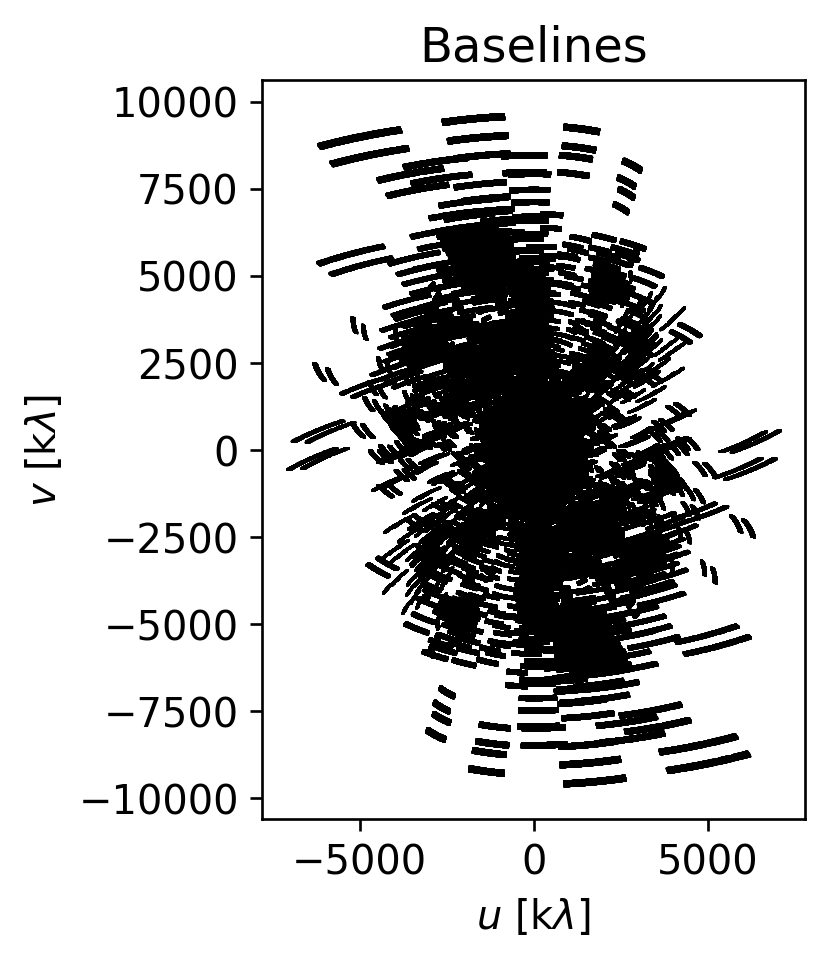

In [10]:
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=0.5, rasterized=True, linewidths=0.0, c="k")
ax.scatter(-uu, -vv, s=0.5, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.set_aspect("equal")
ax.set_title("Baselines")

As you can see, there is a very dense grouping of visibilities with $q < 2000\, \mathrm{k}\lambda$, where $q=\sqrt{u^2 + v^2}$, which primarily consists of data taken in more compact ALMA configurations. There are also several visibilities with baselines > 7,000 ($k\lambda$), which correspond to the extended ALMA configurations and is the reason why the DSHARP data can generate some of the highest spatial resolution images of protoplanetary disks to date.

## The MPoL Gridder Object

Though we have lofty ambitions to make RML images with these DSHARP visibilities, our first goals are much humbler (and pragmatic). Basically, we want to make sure that we are loading the visibilities into MPoL correctly with the right units and in the right format.

One of the simplest ways to do that is by instantiating an MPoL [Gridder](https://mpol-dev.github.io/MPoL/api.html#mpol.gridding.Gridder) object, which can perform basic visibility averaging and inverse Fourier transforms as implemented in CASA. This allows us to check that we're starting from the same basic understanding of the data by creating our own version of a dirty image.

To instantiate an MPoL Gridder object, we need to make a choice for the size of the pixels `cell_size` and the number of pixels per side of our image, `npix`. You can read more about these properties in the [GridCoords](https://mpol-dev.github.io/MPoL/api.html#mpol.coordinates.GridCoords) API Documentation.

We'll follow the CLEAN example and use the same `cell_size` provided in the FITS image.

In [11]:
cell_size = np.abs(header["CDELT1"] * 3600)  # [arcsec]
print("cell_size is {:.4f} arcseconds".format(cell_size))

cell_size is 0.0030 arcseconds


The FITS image was a full 3000x3000 pixels. In general, it is good practice to synthesize an image the full size of the primary beam to avoid potential aliasing from bright sources at the edge of your field, or at least once to check that no bright sources exist in the field of view. That appears to be the rationale of the FITS images provided by the DSHARP team.

Since the DSHARP team has already checked there are no bright sub-mm sources in the FOV, we can save time and just make a smaller image corresponding to the protoplanetary emission. If `cell_size` is 0.003 arcseconds, `npix=512` pixels should be sufficient to make an image approximately 1.5 arcseconds on a side. Now, let's import the relevant MPoL routines and instantiate the Gridder.

In [12]:
from mpol import gridding

gridder = gridding.Gridder(
    cell_size=cell_size,
    npix=512,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data.real,  # separating the real and imaginary values of our data
    data_im=data.imag,
)

## Making diagnostic dirty images

Now, we'll use the [Gridder.get_dirty_image()](../api.rst#mpol.gridding.Gridder.get_dirty_image) routine to average the visibilities to the grid defined by gridder, and perform an inverse Fourier transform to get the dirty image.

There are different ways to weight the visibilities during the averaging process to promote certain image characteristics. More info on the weighting can be found in the [CASA documentation](https://casa.nrao.edu/casadocs-devel/stable/imaging/synthesis-imaging/data-weighting). The MPoL gridder is capable of averaging visibilities using uniform, natural, and Briggs robust weighting. We'll demonstrate this functionality by making several different dirty images under different averaging schemes.

We'll write a function to calculate the dirty image and then plot it.

In [13]:
def image_and_plot(weighting, robust=None):

    img, beam = gridder.get_dirty_image(
        weighting=weighting, robust=robust, unit="Jy/arcsec^2"
    )

    kw = {"origin": "lower", "extent": gridder.coords.img_ext}
    fig, ax = plt.subplots(ncols=1)
    im = ax.imshow(np.squeeze(img), **kw)
    cbar = plt.colorbar(im)
    cbar.set_label(r"$\mathrm{Jy}/\mathrm{arcsec}^2$")

    title = weighting
    if robust is not None:
        title += " r={:.1f}".format(robust)
    ax.set_title(title)
    ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
    ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
    r = 0.7
    plt.xlim(left=r, right=-r)
    plt.ylim(bottom=-r, top=r)

    return np.squeeze(img)

Uniform weighting frequently produces images with the best spatial resolution, but at the expense of sensitivity.

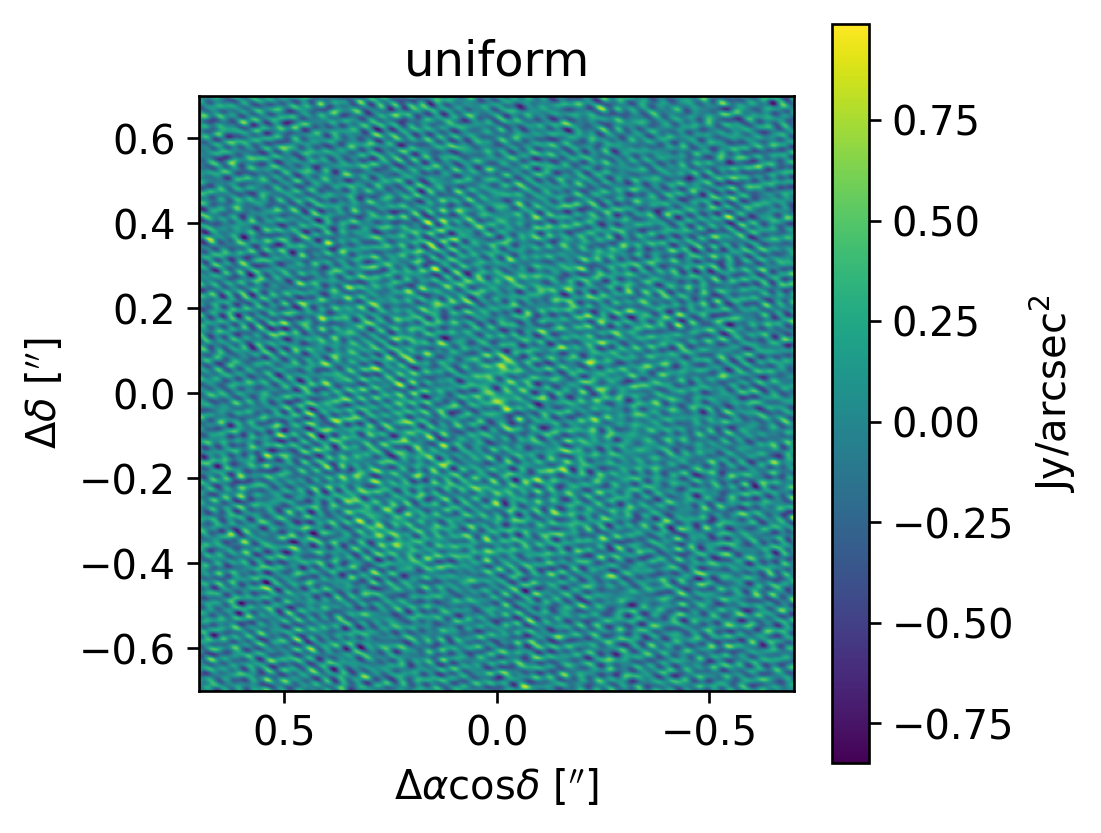

In [14]:
_ = image_and_plot(weighting="uniform")

Natural weighting frequently produces images with the best sensitivity to point sources, but at the expense of spatial resolution.

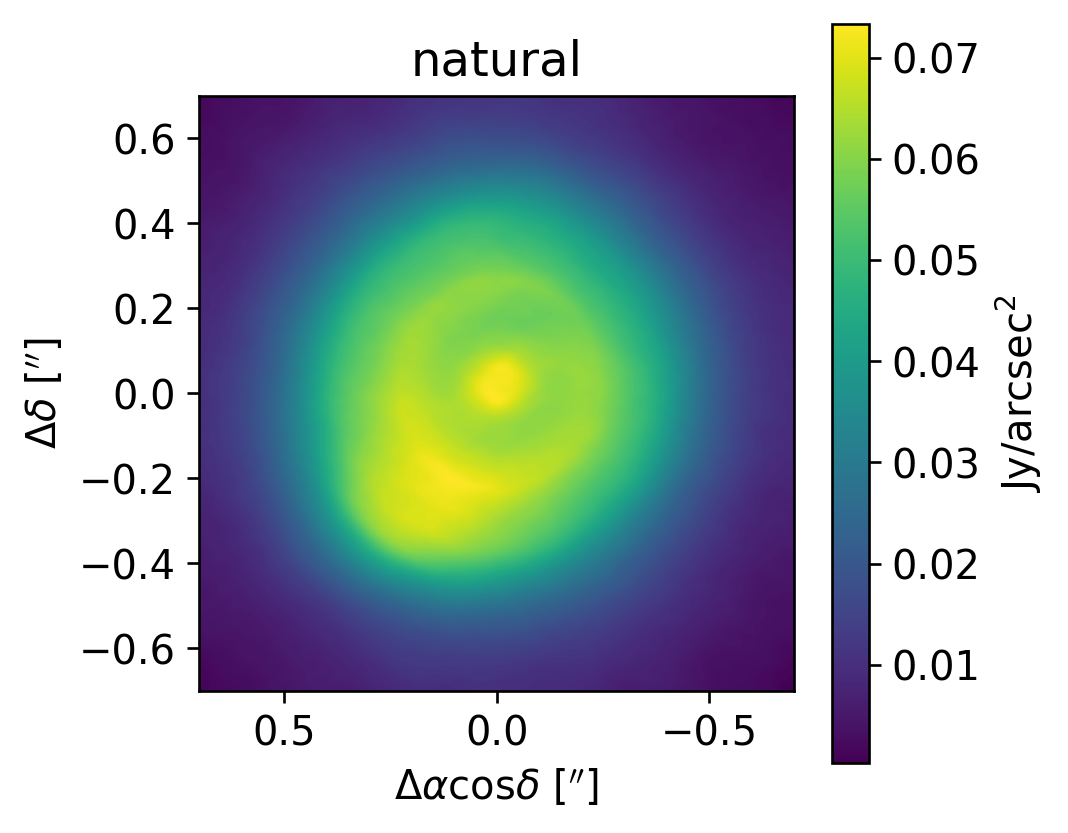

In [15]:
_ = image_and_plot(weighting="natural")

Robust weigting provides a (nonlinear) tradeoff between these two regimes, and some form of robust weighting is typically chosen for ALMA imaging.

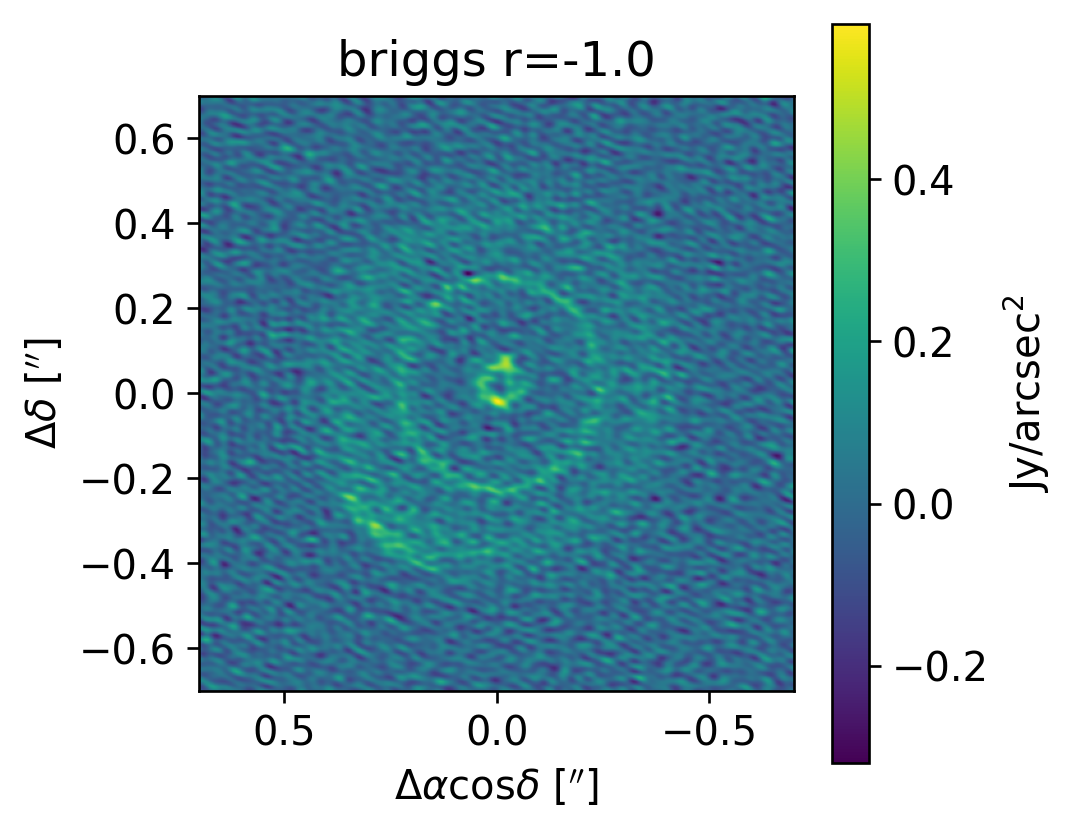

In [16]:
_ = image_and_plot(weighting="briggs", robust=-1.0)

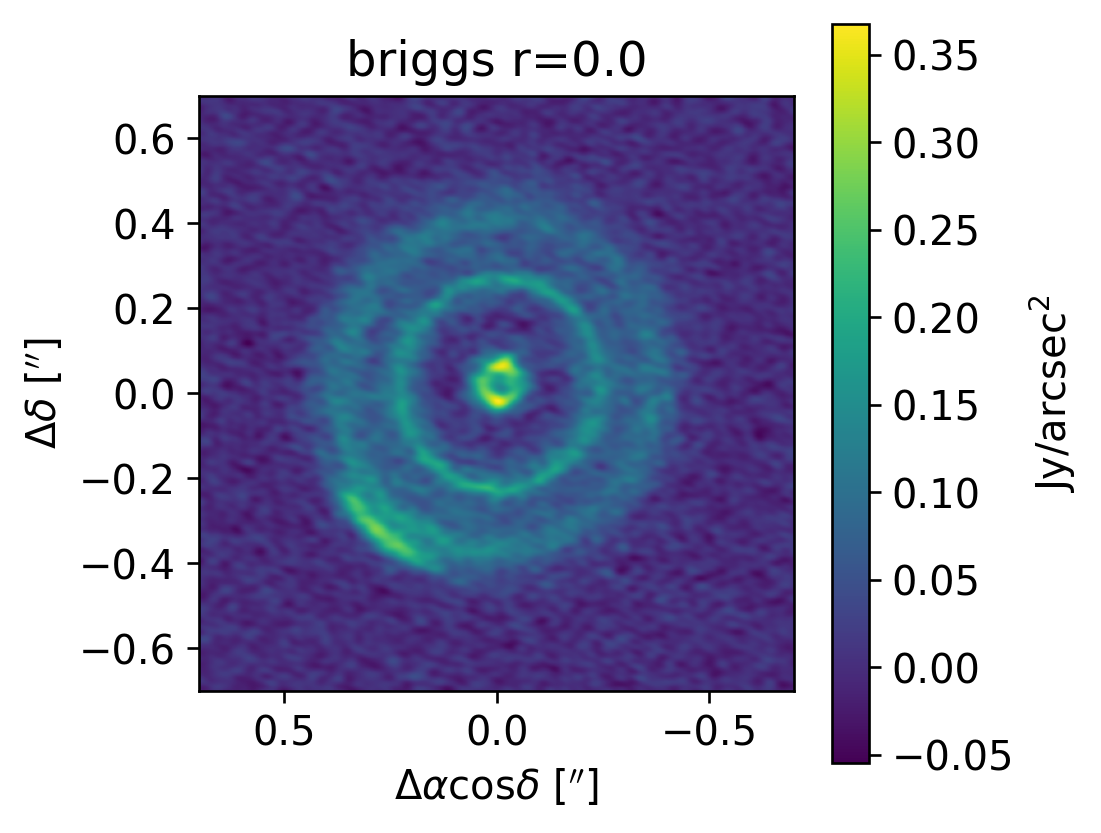

In [17]:
img_robust_0 = image_and_plot(weighting="briggs", robust=0.0)

## Comparing Dirty and CLEANed Images

All in all, it looks like our diagnostic dirty images produced by the MPoL gridder look similar enough in scale and orientation to the DSHARP CLEAN image that we have some confidence that we're reading in the visibility data correctly.

To wrap things up, let's directly compare a dirty image with the DSHARP CLEAN image, which was produced using robust=0.0. (A slight $u,v$ taper was also used, but we'll ignore that detail here).

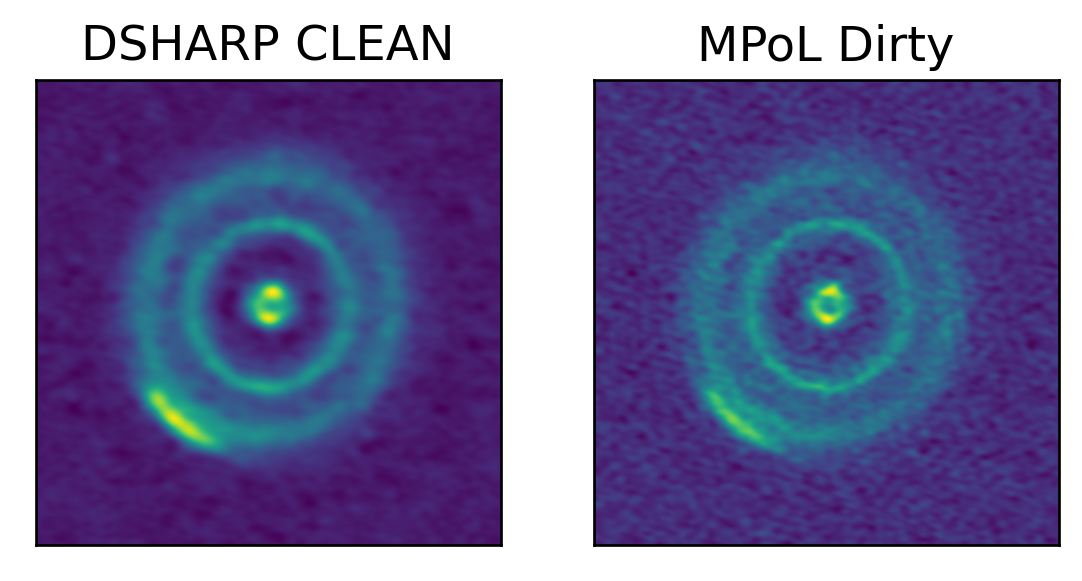

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(5.5, 3))

ax[0].imshow(clean_img, origin="lower", extent=ext)
ax[0].set_title("DSHARP CLEAN")

ax[1].imshow(img_robust_0, origin="lower", extent=gridder.coords.img_ext)
ax[1].set_title("MPoL Dirty")

for a in ax:
    r = 0.7
    a.set_xlim(left=r, right=-r)
    a.set_ylim(bottom=-r, top=r)

    a.xaxis.set_visible(False)
    a.yaxis.set_visible(False)

fig.subplots_adjust()

All in all, it seems like we're on the right track. The diagnostic dirty image that we've produced with the MPoL gridder object is approximately the same size and orientation as the DSHARP CLEAN image, and it retains many of the same morphological features as well. Of course, the dirty image is noisier because it still contains the sidelobe response of the dirty beam---it hasn't been CLEANed yet!